In [1]:
# Update sickit-learn

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 71.1 MB/s 


In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


# Section A: Preprocessing

In [3]:
#Choosed random state
randomState = 10;

# Read csv
bikes_data = pd.read_csv('day.csv');

# Drop unusefull variables
bikes_data = bikes_data.drop(["instant","dteday","casual","registered"], axis=1);

# Peak into the data
bikes_data.describe();

One hot encoding

In [4]:
#One hot encoding of the categorical variables
bikes_data = pd.get_dummies(bikes_data, columns = ['season','yr','mnth','holiday','weekday','workingday','weathersit'], drop_first=False);
bikes_data.head();

Split data and standarize

In [5]:
# Split between train and test
Xtrain, Xtest = train_test_split(bikes_data, test_size=0.4, train_size=0.6, random_state=randomState, shuffle=True);

# Standarize data with the numerical variables. We tried to normalize also the cnt, but the poisson regressor doesn't accept negative values. Also for the other models this didn't have any effect in r2 results. 
numericalVariables = ['temp','atemp','hum','windspeed'];
std_scaler = preprocessing.StandardScaler();
std_scaler.fit(Xtrain[numericalVariables]);
Xtrain[numericalVariables] = std_scaler.transform(Xtrain[numericalVariables]);
Xtest[numericalVariables] = std_scaler.transform(Xtest[numericalVariables]);

Obtain the y column

In [6]:
#Extract the cnt variable and drop it from the train set
Ytrain = Xtrain[["cnt"]];
Xtrain = Xtrain.drop(["cnt"], axis=1);
Ytest = Xtest[["cnt"]];
Xtest = Xtest.drop(["cnt"], axis=1);

# Section B: Poisson regression

In [7]:
poisson_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
alphas = [1e-10,1e-5,1e-4,1e-3,1e-2,0,0.1, 0.5,1,5,10,50,100,1000,10000]
# We calculate the cross-validation metrics for each lambda 
for alpha_val in alphas:
    kf = sklearn.model_selection.KFold(n_splits=5)
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    # We compute the metrics for each fold and then perform the mean.
    for train_index, test_index in kf.split(Xtrain):
        x_train_fold = Xtrain.values[train_index]
        y_train_fold = Ytrain.values[train_index]
        x_test_fold = Xtrain.values[test_index,:]
        y_test_fold = Ytrain.values[test_index]

        pr = linear_model.PoissonRegressor(alpha=alpha_val, max_iter=1000)
        pr.fit(x_train_fold,y_train_fold.ravel())
        y_pred_fold = pr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    poisson_cross_val_metrics.loc['alpha={}'.format(alpha_val),:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]


poisson_cross_val_metrics.sort_values(by='mean R2',ascending=False)

mean MSE mean norm_MSE   mean R2
alpha=50           656076      0.173058  0.826942
alpha=10           659762       0.17407   0.82593
alpha=100          661316      0.174386  0.825614
alpha=5            662094      0.174691  0.825309
alpha=1            665169       0.17551   0.82449
alpha=0.5          665698      0.175651  0.824349
alpha=0.1          666155      0.175773  0.824227
alpha=0.01         666263      0.175802  0.824198
alpha=0.001        666274      0.175805  0.824195
alpha=1e-05        666275      0.175805  0.824195
alpha=0.0001       666275      0.175805  0.824195
alpha=1e-10        666275      0.175805  0.824195
alpha=0            666275      0.175805  0.824195
alpha=1000         889588      0.233789  0.766211
alpha=10000   2.13037e+06      0.558491  0.441509

Model with best alpha (= 50) results

In [8]:
# We can see that the best alpha is 50, so we will use this value, even though there are not many differences. 
poissonReg = sklearn.linear_model.PoissonRegressor(alpha=50, max_iter=1000).fit(Xtrain, Ytrain.values.ravel());
print("Poisson coefs:\n",poissonReg.coef_);
print("\nPoisson train error:",poissonReg.score(Xtrain,Ytrain.values.ravel()));
print("Poisson test error:",poissonReg.score(Xtest,Ytest.values.ravel()));

Poisson coefs:
 [ 0.05223542  0.16955318 -0.05349175 -0.04429246 -0.23660219  0.0470599
  0.01912864  0.17041413 -0.22909349  0.22909397 -0.11656607 -0.01365138
  0.04240622  0.02400826  0.09384287 -0.00291714 -0.12212919  0.01075122
  0.09407987  0.05161062 -0.02173865 -0.03969614  0.05563235 -0.05563187
 -0.03140901 -0.01278676  0.00096216 -0.02431796  0.00236225 -0.00309057
  0.06828036 -0.01876052  0.018761    0.15633311  0.0726201  -0.22895273]

Poisson train error: 0.8445080507481402
Poisson test error: 0.7709148172201625


# Section C: Linear regression

In [9]:
lr = LinearRegression();
lr.fit(Xtrain,Ytrain);

train_folds_r2 = cross_val_score(lr, Xtrain,Ytrain, cv=5, scoring='r2');
print("Cross validation error in folds:",train_folds_r2);
print("Cross validation mean error:",np.mean(train_folds_r2));
print("Linear coefs:\n",lr.coef_);
print("\nLinear train error:",lr.score(Xtrain,Ytrain));
print("Linear test error:",lr.score(Xtest,Ytest));

Cross validation error in folds: [0.85607534 0.88261076 0.83934276 0.85667238 0.78398719]
Cross validation mean error: 0.8437376883858967
Linear coefs:
 [[ -542.1373068   1303.85870817  -197.35586413  -149.19809713
   -929.56079864     7.35086557   165.38806865   756.82186443
  -1006.07975332  1006.07975332  -321.68872916  -203.95078423
    107.21171307   100.03369404   582.87188624   293.59676135
   -525.37241065   212.26630657   571.35631582   152.31271952
   -535.02556225  -433.61191032   219.54006987  -219.54006987
   -194.10217348  -118.59594729   -57.93920774    -2.00586904
     54.03058351    -1.58575938   320.19837343   -93.44386992
     93.44386992   674.65537767   223.40891617  -898.06429384]]

Linear train error: 0.8647141445970717
Linear test error: 0.7988576571068192


# Section D: Lasso regression

In [10]:
lassoReg = LassoCV(cv=5,random_state=randomState).fit(Xtrain,Ytrain.values.ravel());
print("Lasso best alpha:",lassoReg.alpha_);
print("Lasso coefs:\n",lassoReg.coef_);
print("\nLasso train error:",lassoReg.score(Xtrain,Ytrain));
print("Lasso test error:",lassoReg.score(Xtest,Ytest));

Lasso best alpha: 4.74899558196033
Lasso coefs:
 [ 0.00000000e+00  8.85256931e+02 -2.14476370e+02 -1.68516134e+02
 -1.14781021e+03  0.00000000e+00 -0.00000000e+00  4.08515132e+02
 -1.99510428e+03  1.35782748e-10 -7.22643176e+01 -0.00000000e+00
  9.95180485e+01 -0.00000000e+00  3.11999864e+02  0.00000000e+00
 -6.60696547e+02  0.00000000e+00  4.60599131e+02  2.56142220e+02
 -2.26033045e+02 -1.50510642e+02  5.52908570e+02 -2.04430217e-11
 -3.00289654e+02 -7.70014914e+01 -0.00000000e+00  0.00000000e+00
  2.54061871e+01  0.00000000e+00  1.23722499e+02 -7.47136256e-01
  3.97960719e-14  4.10409674e+02 -0.00000000e+00 -9.99129962e+02]

Lasso train error: 0.8622328858047182
Lasso test error: 0.8044769748235057


# Section E: Comparing results

In [11]:

lassoPredictTrain = lassoReg.predict(Xtrain)
#lassoPredictTrainError = abs(lassoPredictTrain-Ytrain["cnt"].to_numpy())
lassoPredictTest = lassoReg.predict(Xtest)
#lassoPredictTestError = abs(Ytest["cnt"].to_numpy()-lassoPredictTest)


poissonPredictTrain = poissonReg.predict(Xtrain)
#poissonPredictTrainError = abs(Ytrain["cnt"].to_numpy()-poissonPredictTrain)
poissonPredictTest = poissonReg.predict(Xtest)
#poissonPredictTestError = abs(Ytest["cnt"].to_numpy()-poissonPredictTest)


linearPredictTrain = lr.predict(Xtrain)
#linearPredictTrainError = abs(Ytrain["cnt"].to_numpy()-linearPredictTrain.transpose()[0])
linearPredictTest = lr.predict(Xtest)
#linearPredictTestError = abs(Ytest["cnt"].to_numpy()-linearPredictTest.transpose()[0])

XTrain = [i for i in range(0,len(Ytrain))]
XTest = [i for i in range(0,len(Ytest))]

### e - QUESTION 1

####Linear VS Real

Full Plot

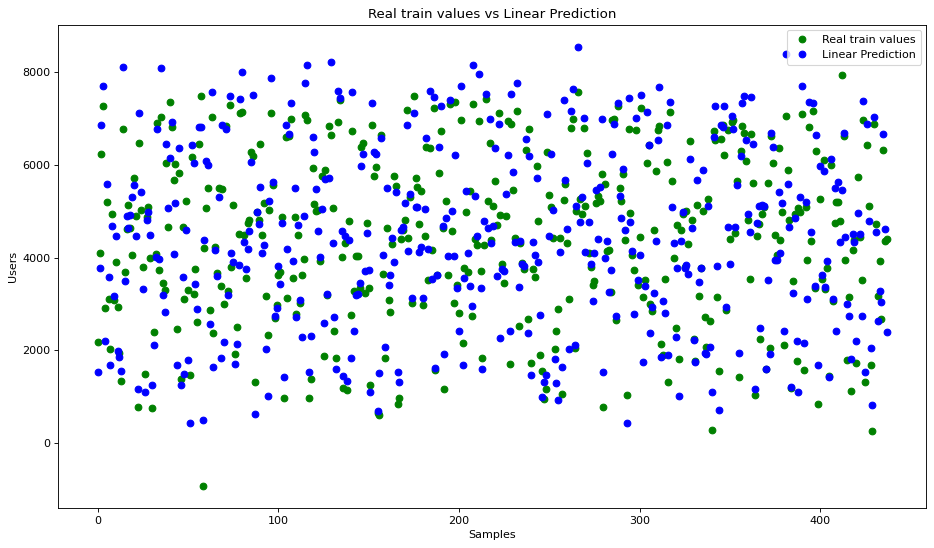

In [12]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,linearPredictTrain,'go')
plt.plot(XTrain,Ytrain,'bo')
plt.title('Real train values vs Linear Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Linear Prediction'])
plt.show()

First 50 plot

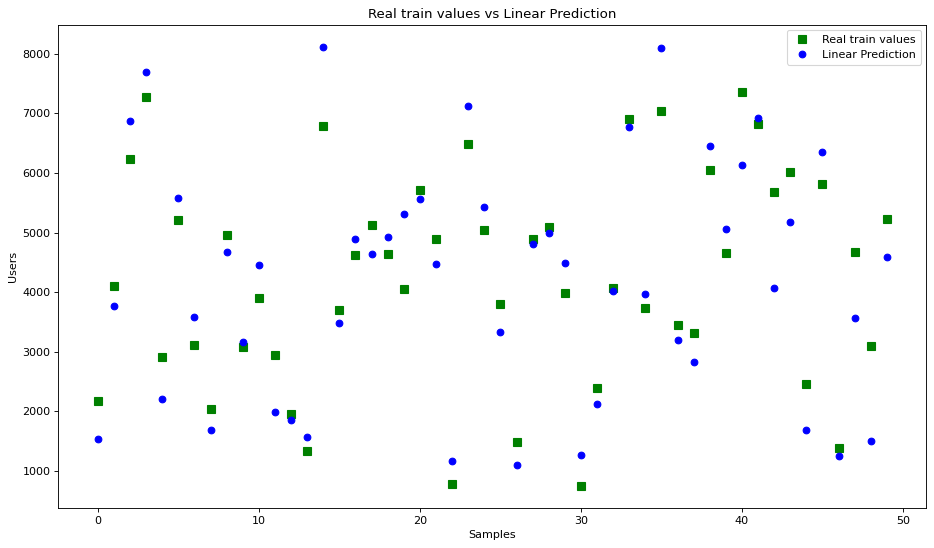

In [13]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain[0:50],linearPredictTrain[0:50],'gs', markersize=8)
plt.plot(XTrain[0:50],Ytrain[0:50],'bo')
plt.title('Real train values vs Linear Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Linear Prediction'])
plt.show()

Full plot

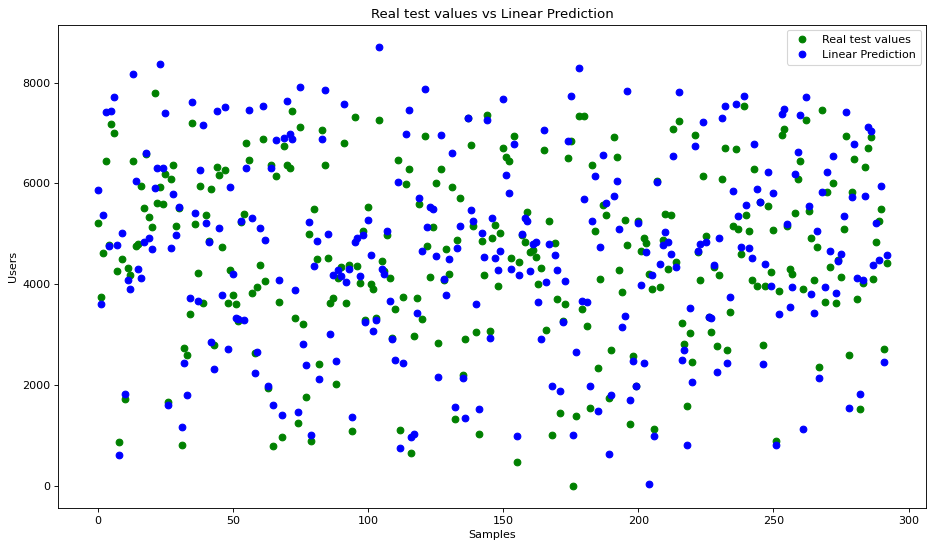

In [14]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,linearPredictTest,'go')
plt.plot(XTest,Ytest,'bo')
plt.title('Real test values vs Linear Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Linear Prediction'])
plt.show()

First 50 plot

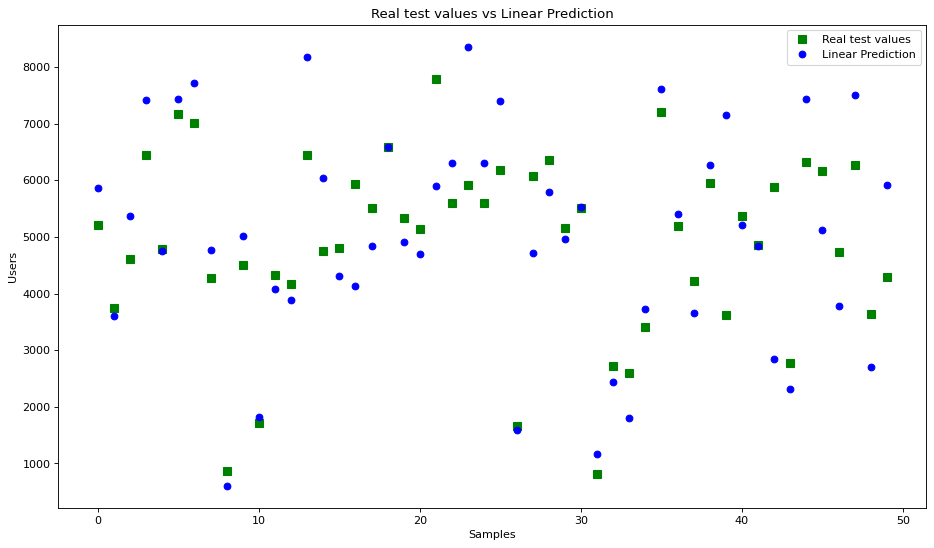

In [15]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest[0:50],linearPredictTest[0:50],'gs', markersize=8)
plt.plot(XTest[0:50],Ytest[0:50],'bo')
plt.title('Real test values vs Linear Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Linear Prediction'])
plt.show()

####Poisson vs Real

Full plot

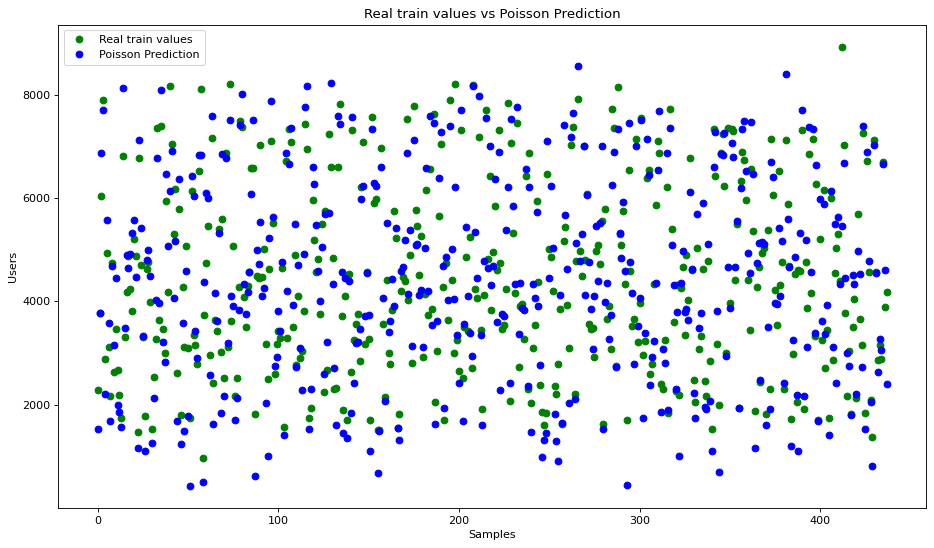

In [16]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,poissonPredictTrain,'go')
plt.plot(XTrain,Ytrain,'bo')
plt.title('Real train values vs Poisson Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Poisson Prediction'])
plt.show()

First 50 plot

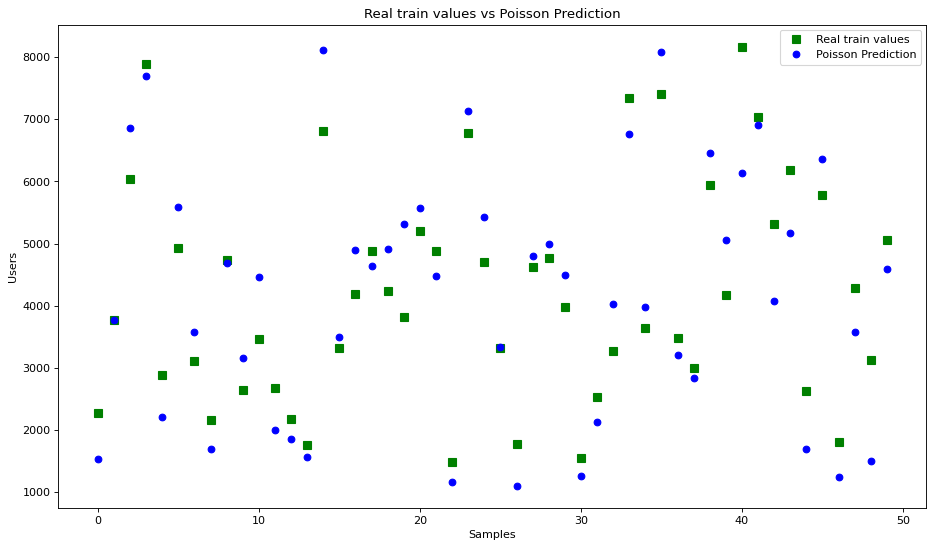

In [17]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain[0:50],poissonPredictTrain[0:50],'gs', markersize=8)
plt.plot(XTrain[0:50],Ytrain[0:50],'bo')
plt.title('Real train values vs Poisson Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Poisson Prediction'])
plt.show()

Full plot

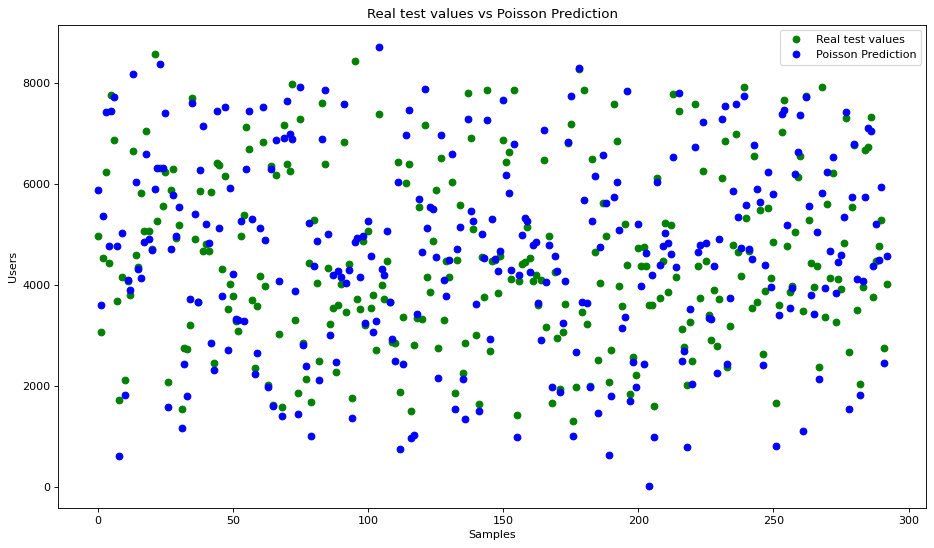

In [18]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,poissonPredictTest,'go')
plt.plot(XTest,Ytest,'bo')
plt.title('Real test values vs Poisson Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Poisson Prediction'])
plt.show()

First 50 plot

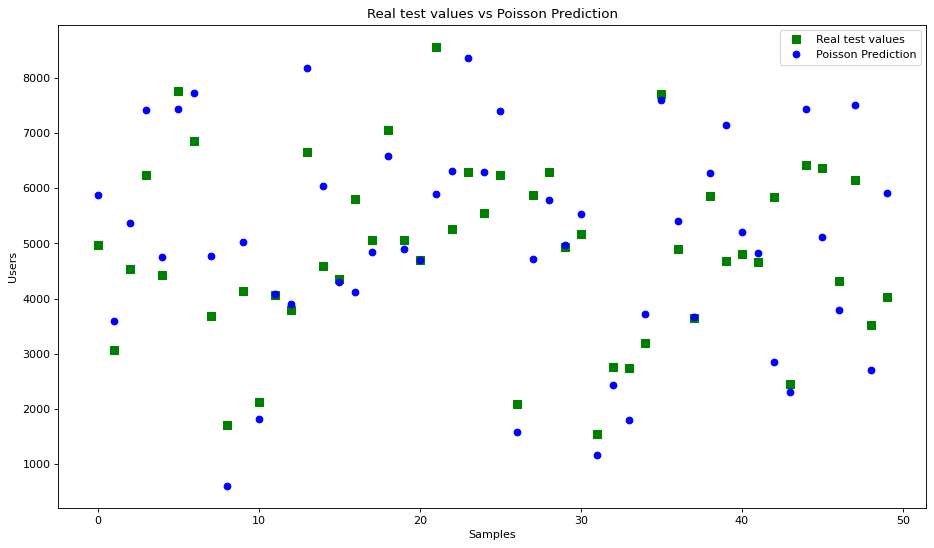

In [19]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest[0:50],poissonPredictTest[0:50],'gs', markersize=8)
plt.plot(XTest[0:50],Ytest[0:50],'bo')
plt.title('Real test values vs Poisson Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Poisson Prediction'])
plt.show()

####Lasso vs Real

Full plot

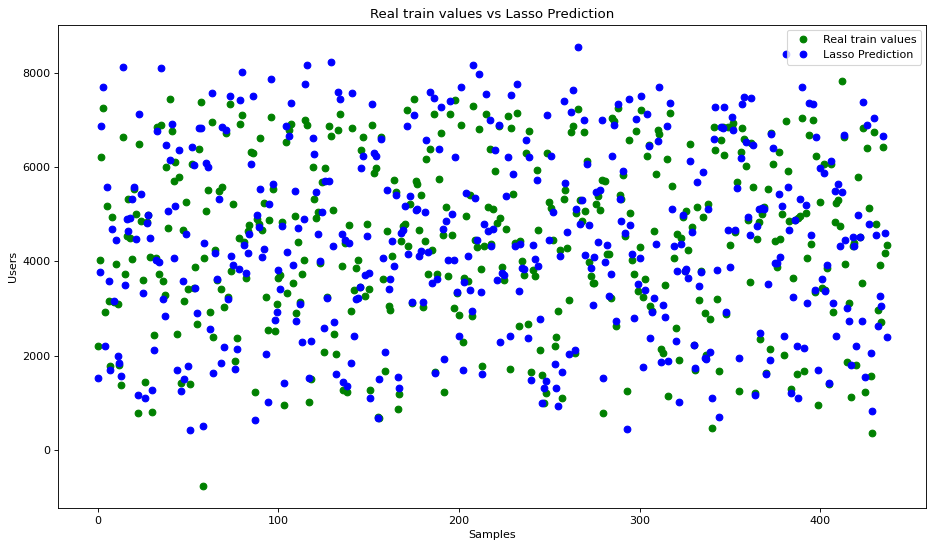

In [20]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,lassoPredictTrain,'go')
plt.plot(XTrain,Ytrain,'bo')
plt.title('Real train values vs Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Lasso Prediction'])
plt.show()

First 50 plot

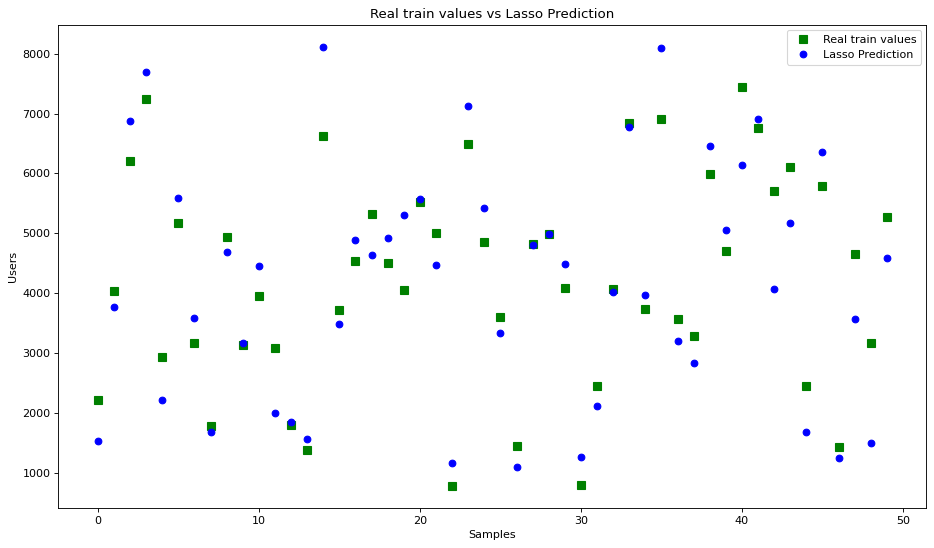

In [21]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain[0:50],lassoPredictTrain[0:50],'gs', markersize=8)
plt.plot(XTrain[0:50],Ytrain[0:50],'bo')
plt.title('Real train values vs Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Lasso Prediction'])
plt.show()

Full plot

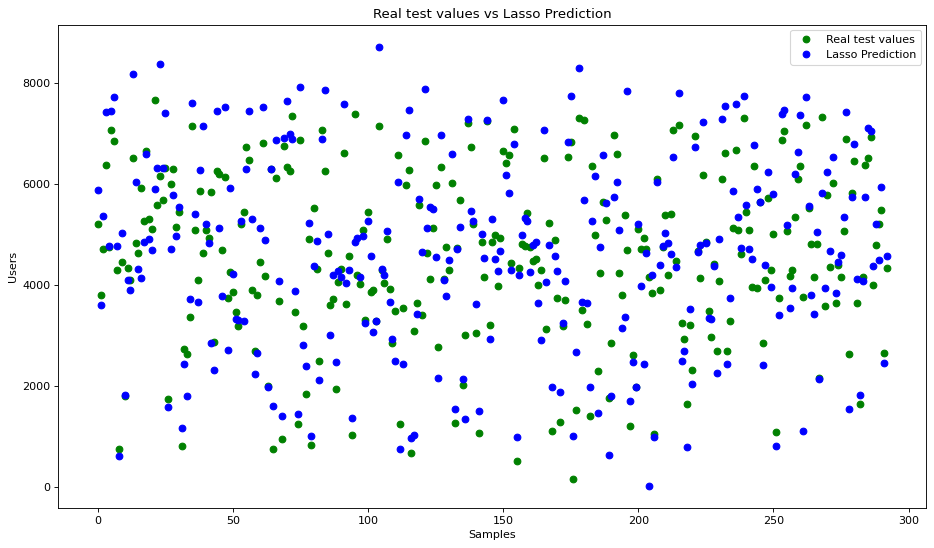

In [22]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,lassoPredictTest,'go')
plt.plot(XTest,Ytest,'bo')
plt.title('Real test values vs Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Lasso Prediction'])
plt.show()

First 50 plot

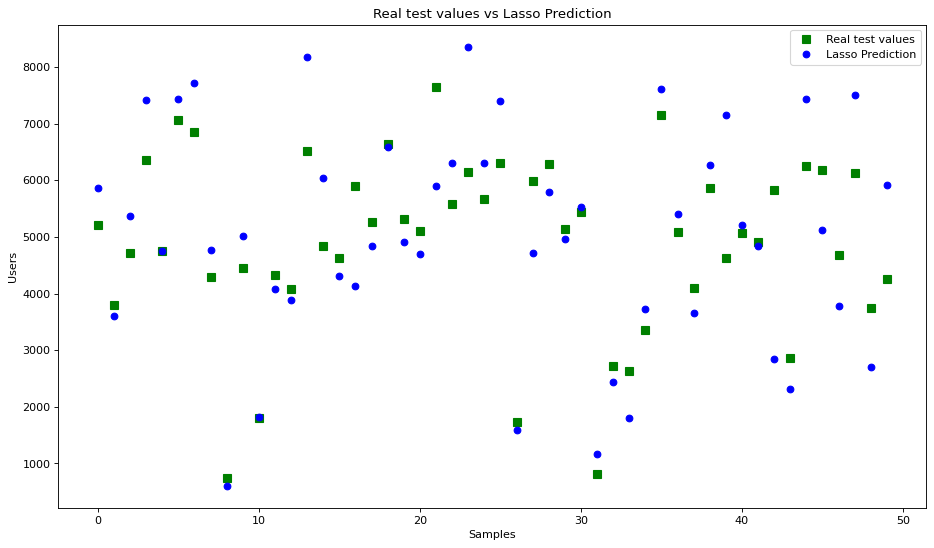

In [23]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest[0:50],lassoPredictTest[0:50],'gs', markersize=8)
plt.plot(XTest[0:50],Ytest[0:50],'bo')
plt.title('Real test values vs Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Lasso Prediction'])
plt.show()

###e - QUESTION 2:

In [24]:
table = pd.DataFrame(columns=['Linear weight', 'Lasso weight'])

for e in range(0,len(Xtrain.columns)):
  table.loc[Xtrain.columns[e],:] = [round(lr.coef_[0][e],3),round(lassoReg.coef_[e],3)]

print(table)

             Linear weight Lasso weight
temp              -542.137            0
atemp              1303.86      885.257
hum               -197.356     -214.476
windspeed         -149.198     -168.516
season_1          -929.561     -1147.81
season_2             7.351            0
season_3           165.388           -0
season_4           756.822      408.515
yr_0              -1006.08      -1995.1
yr_1               1006.08            0
mnth_1            -321.689      -72.264
mnth_2            -203.951           -0
mnth_3             107.212       99.518
mnth_4             100.034           -0
mnth_5             582.872          312
mnth_6             293.597            0
mnth_7            -525.372     -660.697
mnth_8             212.266            0
mnth_9             571.356      460.599
mnth_10            152.313      256.142
mnth_11           -535.026     -226.033
mnth_12           -433.612     -150.511
holiday_0           219.54      552.909
holiday_1          -219.54           -0


###e - QUESTION 3


#### Comparison plots

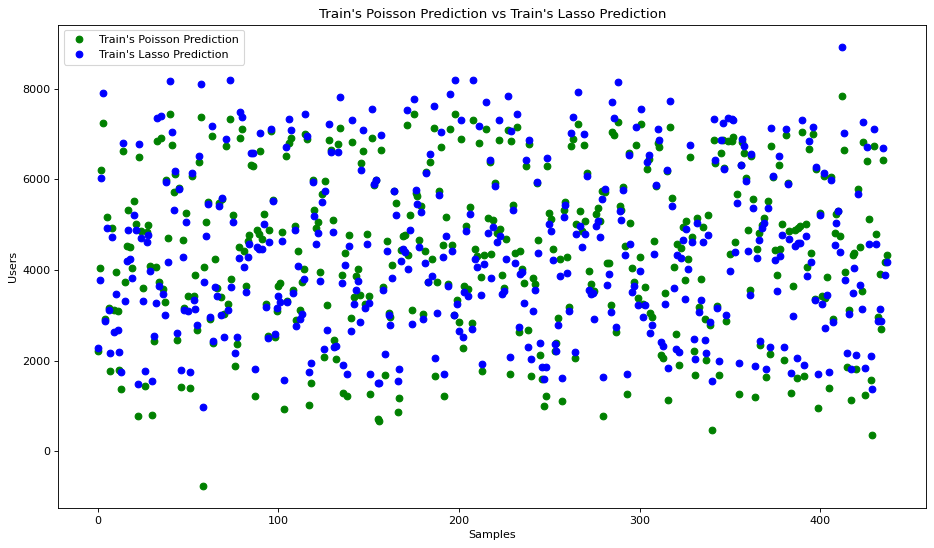

In [25]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,lassoPredictTrain,'go')
plt.plot(XTrain,poissonPredictTrain,'bo')
plt.title('Train\'s Poisson Prediction vs Train\'s Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Poisson Prediction', 'Train\'s Lasso Prediction'])
plt.show()

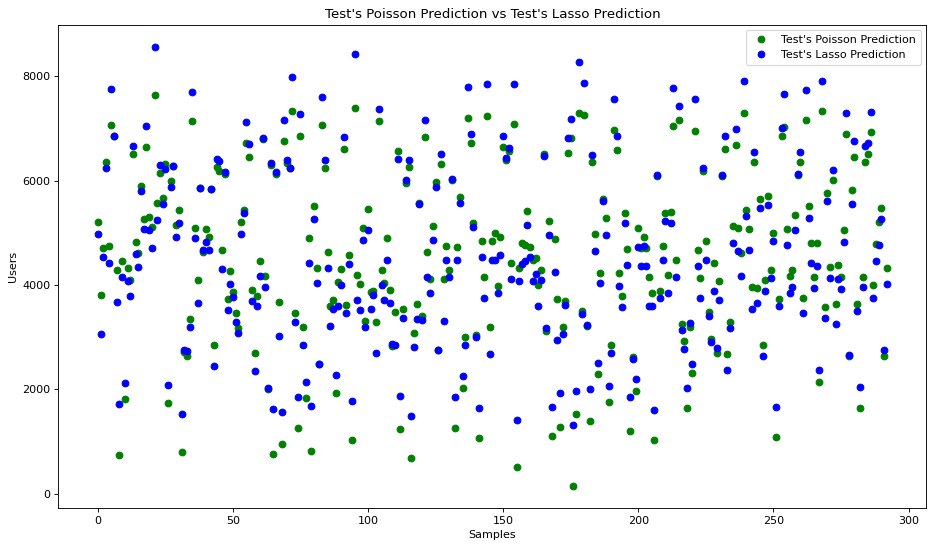

In [26]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,lassoPredictTest,'go')
plt.plot(XTest,poissonPredictTest,'bo')
plt.title('Test\'s Poisson Prediction vs Test\'s Lasso Prediction')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Poisson Prediction', 'Test\'s Lasso Prediction'])
plt.show()

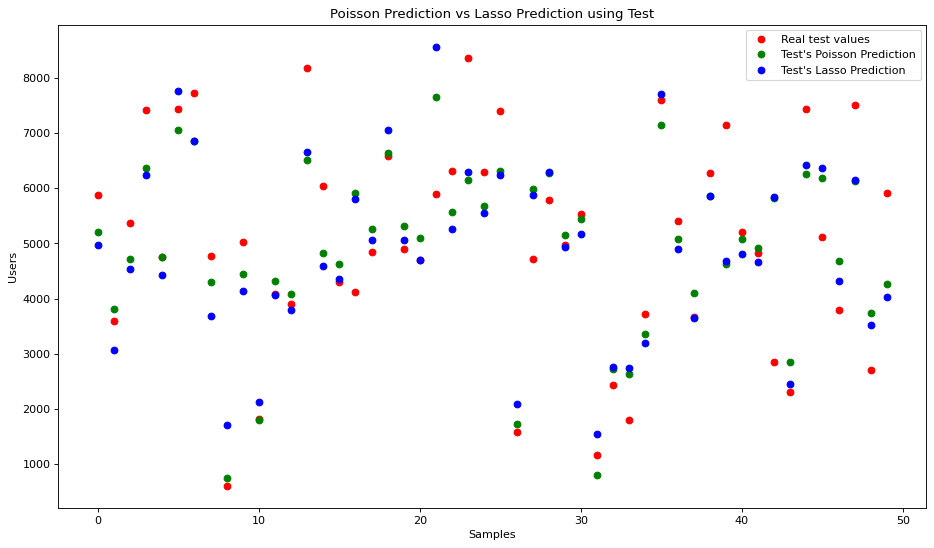

In [27]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest[0:50],Ytest[0:50],'ro')
plt.plot(XTest[0:50],lassoPredictTest[0:50],'go')
plt.plot(XTest[0:50],poissonPredictTest[0:50],'bo')
plt.title('Poisson Prediction vs Lasso Prediction using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real test values','Test\'s Poisson Prediction', 'Test\'s Lasso Prediction'])
plt.show()

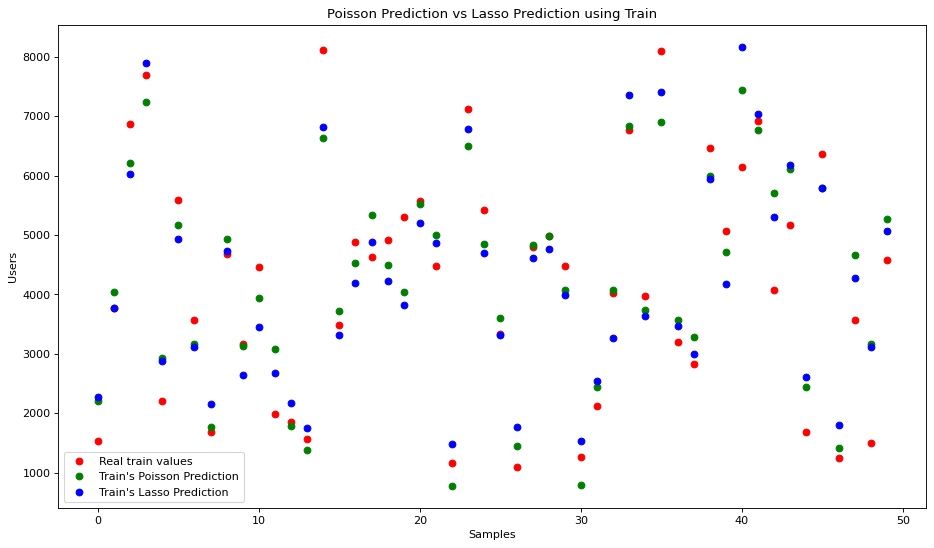

In [28]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain[0:50],Ytrain[0:50],'ro')
plt.plot(XTrain[0:50],lassoPredictTrain[0:50],'go')
plt.plot(XTrain[0:50],poissonPredictTrain[0:50],'bo')
plt.title('Poisson Prediction vs Lasso Prediction using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Real train values','Train\'s Poisson Prediction', 'Train\'s Lasso Prediction'])
plt.show()

#### Comparison ordered plots

In [29]:
Ytrainnp = Ytrain.to_numpy()
sortedModel = sorted(zip(Ytrainnp,poissonPredictTrain, linearPredictTrain, lassoPredictTrain))
YtrainSorted, poissonPredictTrainSorted, linearPredictTrainSorted, lassoPredictTrainSorted = zip(*sortedModel)

Ytestnp = Ytest.to_numpy()
sortedModel = sorted(zip(Ytestnp,poissonPredictTest, linearPredictTest, lassoPredictTest))
YtestSorted,poissonPredictTestSorted, linearPredictTestSorted, lassoPredictTestSorted = zip(*sortedModel)

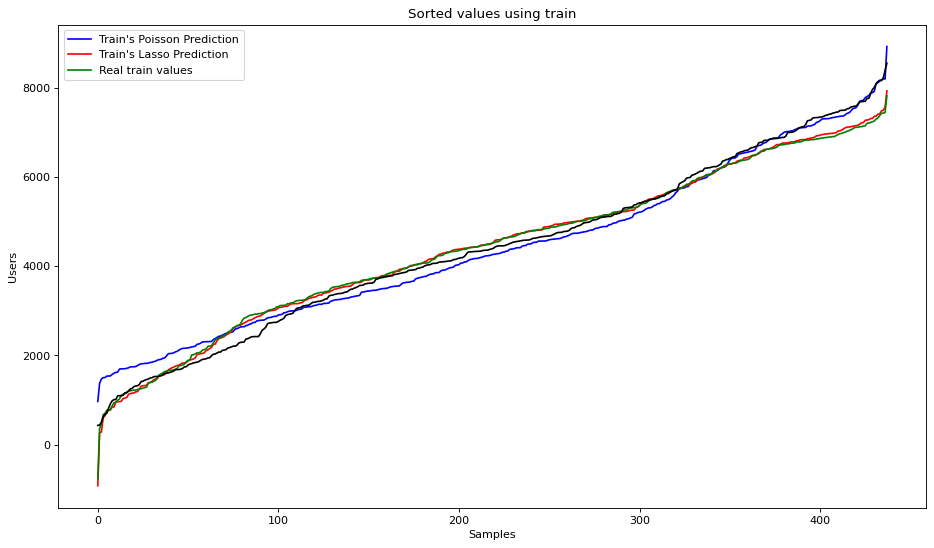

In [30]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,sorted(poissonPredictTrainSorted),'b')
plt.plot(XTrain,sorted(linearPredictTrainSorted),'r')
plt.plot(XTrain,sorted(lassoPredictTrainSorted),'g')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Sorted values using train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Poisson Prediction', 'Train\'s Lasso Prediction','Real train values'])
plt.show()

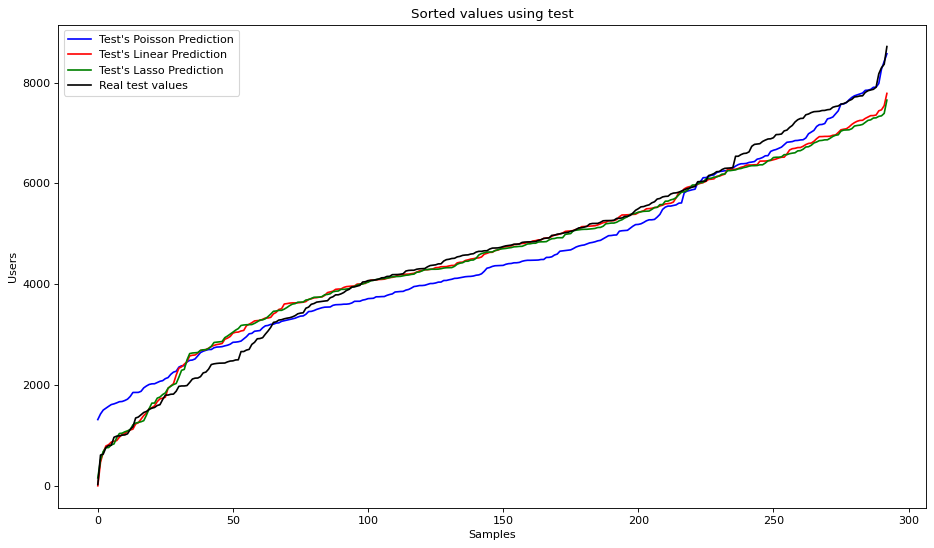

In [31]:
figure(figsize=(14, 8), dpi=80)

plt.plot(XTest,sorted(poissonPredictTestSorted),'b')
plt.plot(XTest,sorted(linearPredictTestSorted),'r')
plt.plot(XTest,sorted(lassoPredictTestSorted),'g')
plt.plot(XTest,YtestSorted,'k')
plt.title('Sorted values using test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Poisson Prediction', 'Test\'s Linear Prediction', 'Test\'s Lasso Prediction','Real test values'])
plt.show()

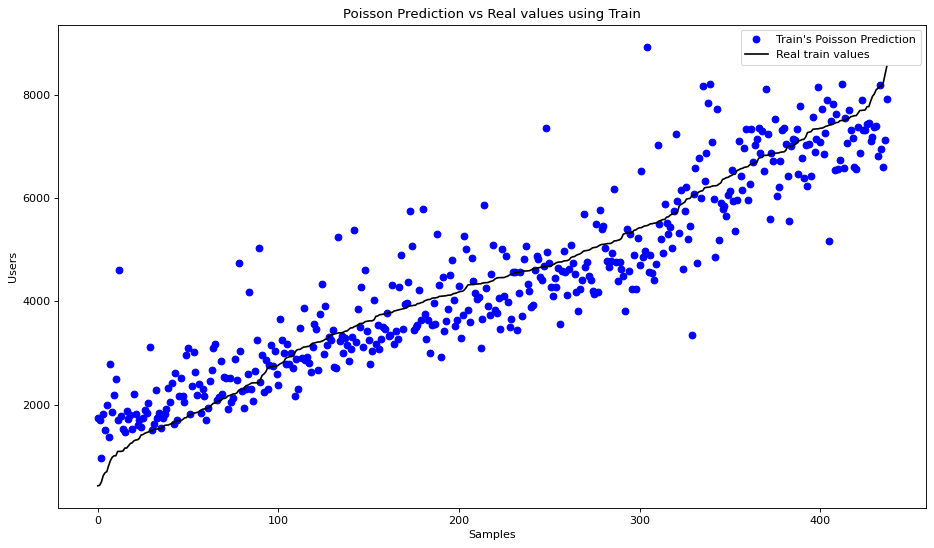

In [32]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,poissonPredictTrainSorted,'bo')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Poisson Prediction vs Real values using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Poisson Prediction','Real train values'])
plt.show()

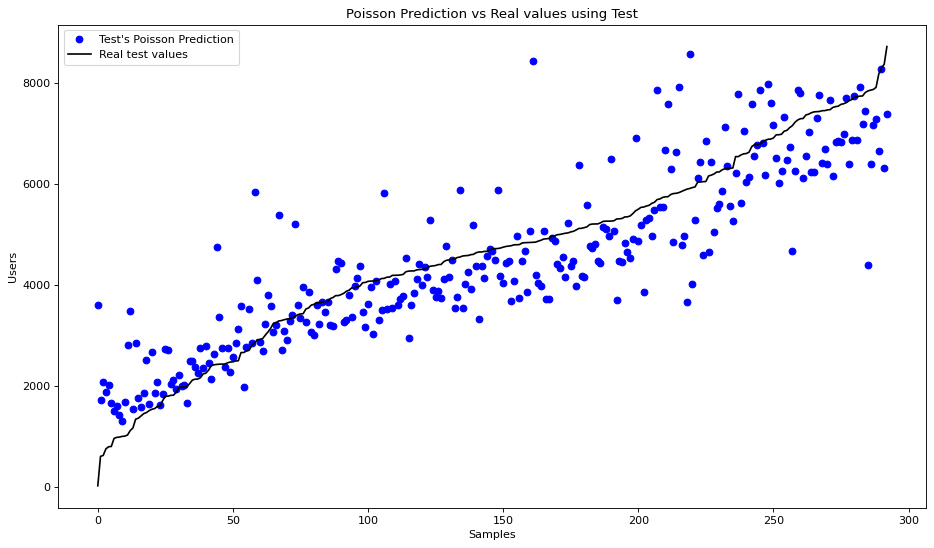

In [33]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,poissonPredictTestSorted,'bo')
plt.plot(XTest,YtestSorted,'k')
plt.title('Poisson Prediction vs Real values using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Poisson Prediction','Real test values'])
plt.show()

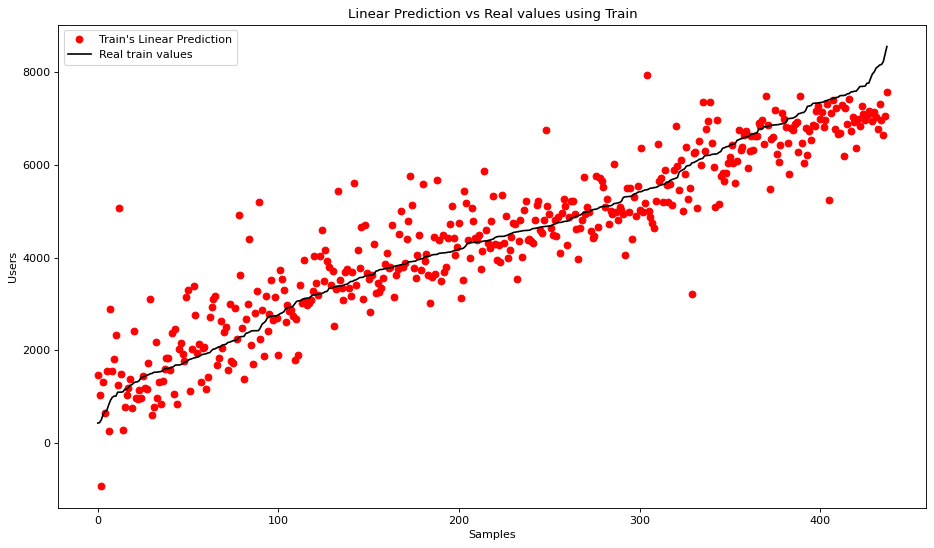

In [34]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,linearPredictTrainSorted,'ro')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Linear Prediction vs Real values using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Linear Prediction','Real train values'])
plt.show()

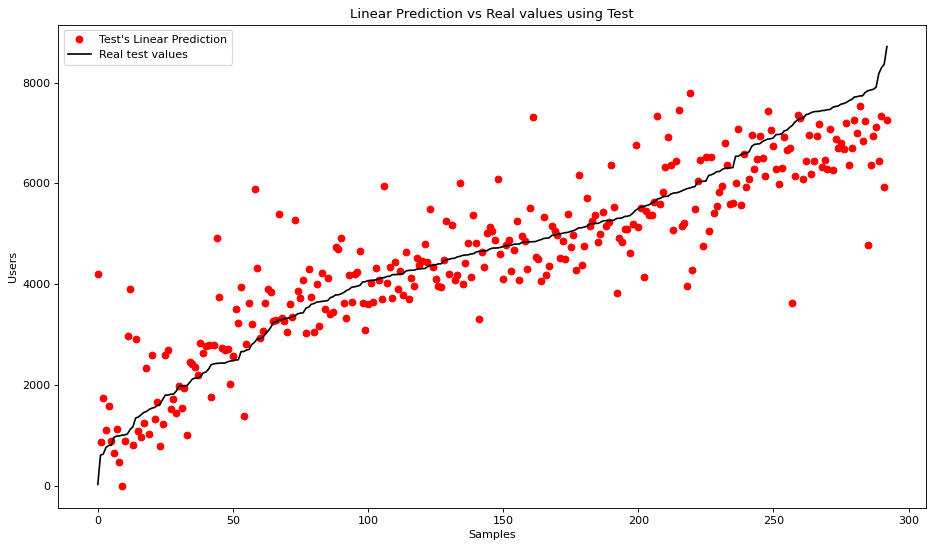

In [35]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,linearPredictTestSorted,'ro')
plt.plot(XTest,YtestSorted,'k')
plt.title('Linear Prediction vs Real values using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Linear Prediction','Real test values'])
plt.show()

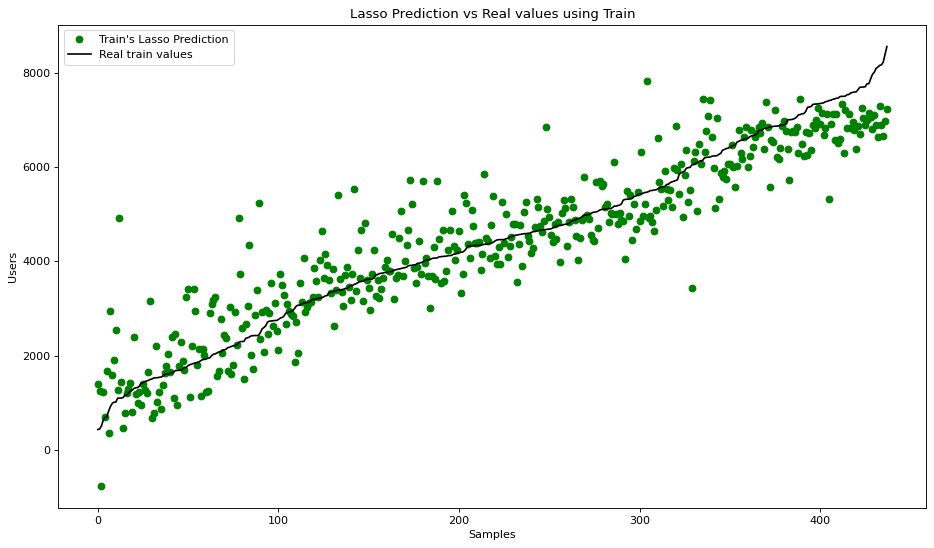

In [36]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,lassoPredictTrainSorted,'go')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Lasso Prediction vs Real values using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Lasso Prediction','Real train values'])
plt.show()

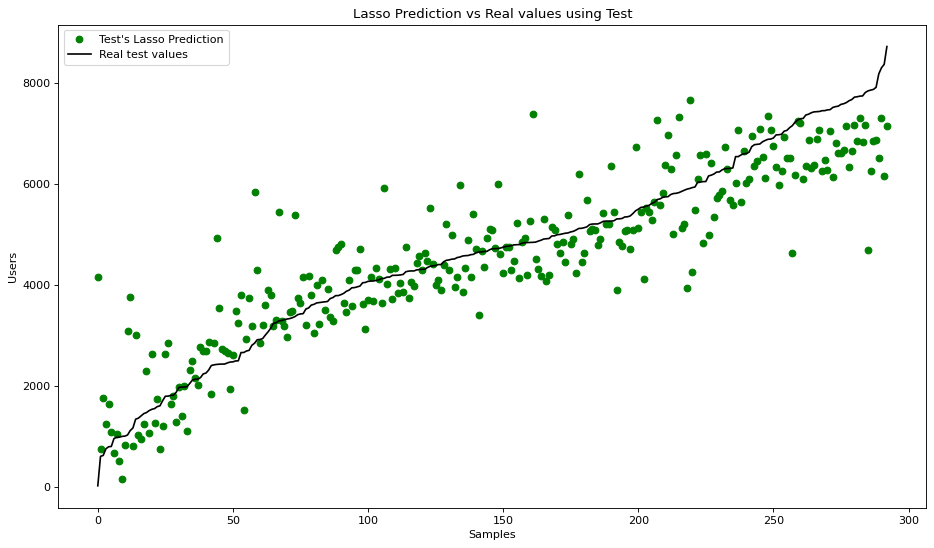

In [37]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,lassoPredictTestSorted,'go')
plt.plot(XTest,YtestSorted,'k')
plt.title('Lasso Prediction vs Real values using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Lasso Prediction','Real test values'])
plt.show()

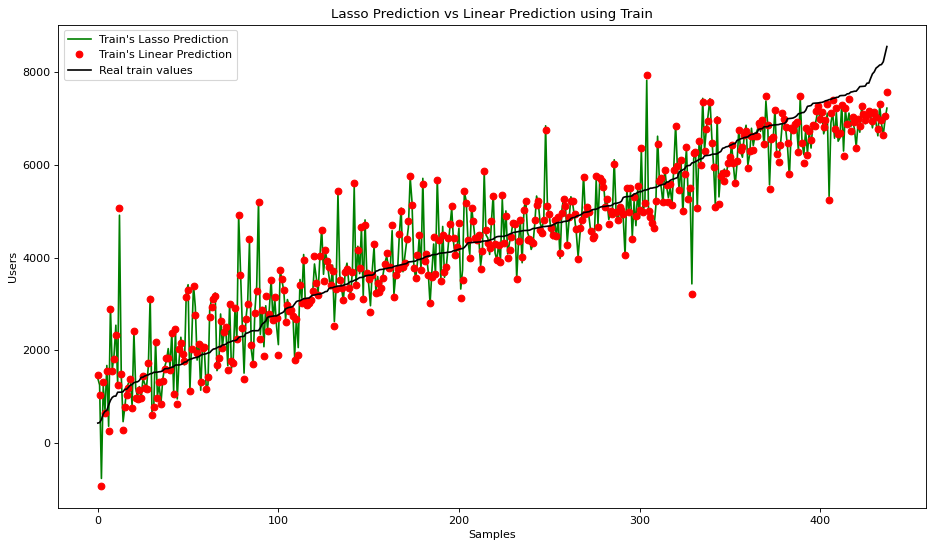

In [38]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,lassoPredictTrainSorted,'g')
plt.plot(XTrain,linearPredictTrainSorted,'ro')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Lasso Prediction vs Linear Prediction using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Lasso Prediction','Train\'s Linear Prediction','Real train values'])
plt.show()

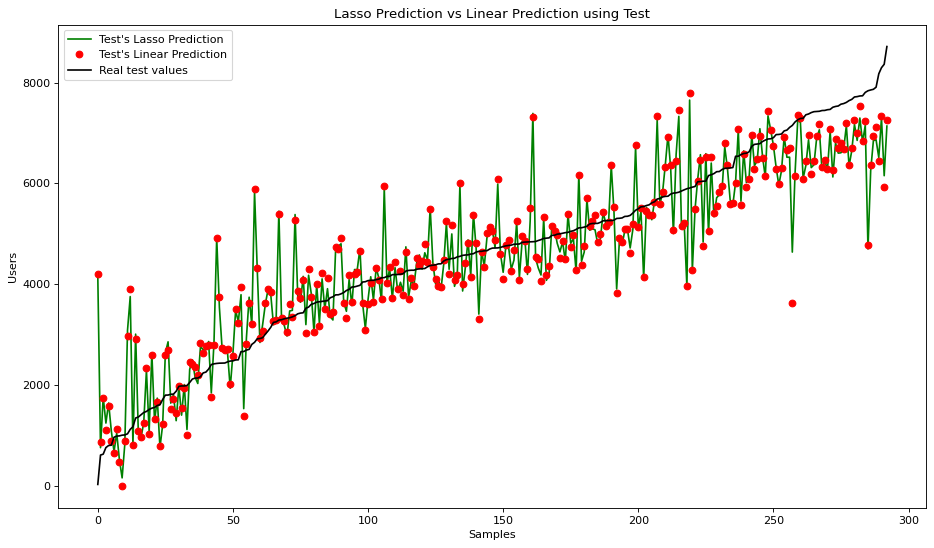

In [39]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,lassoPredictTestSorted,'g')
plt.plot(XTest,linearPredictTestSorted,'ro')
plt.plot(XTest,YtestSorted,'k')
plt.title('Lasso Prediction vs Linear Prediction using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Lasso Prediction','Test\'s Linear Prediction','Real test values'])
plt.show()

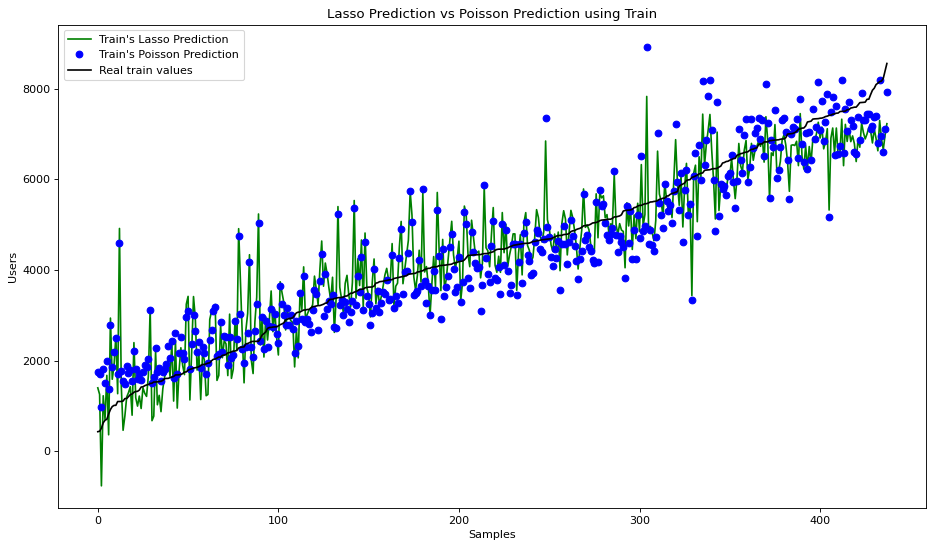

In [40]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTrain,lassoPredictTrainSorted,'g')
plt.plot(XTrain,poissonPredictTrainSorted,'bo')
plt.plot(XTrain,YtrainSorted,'k')
plt.title('Lasso Prediction vs Poisson Prediction using Train')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Train\'s Lasso Prediction','Train\'s Poisson Prediction','Real train values'])
plt.show()

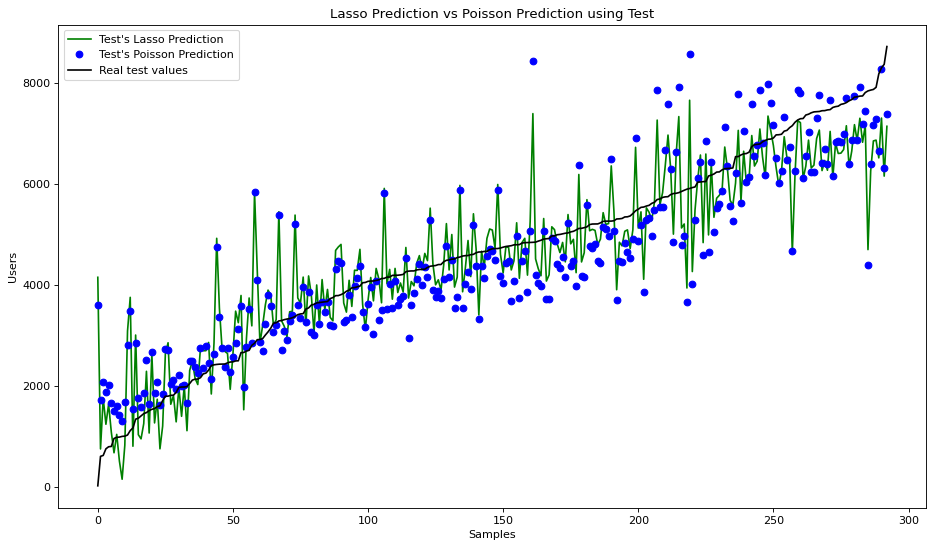

In [41]:
figure(figsize=(14, 8), dpi=80)
plt.plot(XTest,lassoPredictTestSorted,'g')
plt.plot(XTest,poissonPredictTestSorted,'bo')
plt.plot(XTest,YtestSorted,'k')
plt.title('Lasso Prediction vs Poisson Prediction using Test')
plt.xlabel('Samples')
plt.ylabel('Users')
plt.legend(['Test\'s Lasso Prediction','Test\'s Poisson Prediction','Real test values'])
plt.show()